In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path
import copy

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
import xarray as xr
from gempyor import config, model_info, outcomes, seir, inference_parameter, logloss, inference

import os
from multiprocessing import cpu_count
from gempyor.inference import GempyorInference
import gempyor.postprocess_inference

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"
import emcee

from dime_sampler import DIMEMove
import multiprocessing

config_filepath = f"simple_usa_statelevel.yml"
project_path = ""


nwalkers = 200
#config_path = f"config_CACOMD_maternal_v8_emcee.yml"
#nwalkers = 128
niter = 100
nsamples = nwalkers/5 # numbe of likelyhood eval to write to disk...
thin=5

run_id = f"{nwalkers}_llik:norm_5_big"

ncpu = cpu_count()
print(f"found {ncpu} CPUs, using these")

gempyor_inference = GempyorInference(
        config_filepath=config_filepath,
        run_id=run_id,
        prefix=None,
        first_sim_index=1,
        stoch_traj_flag=False,
        rng_seed=None,
        nslots=1,
        inference_filename_prefix="",  # usually for {global or chimeric}/{intermediate or final}
        inference_filepath_suffix="",  # usually for the slot_id
        out_run_id=None,  # if out_run_id is different from in_run_id, fill this
        out_prefix=None,  # if out_prefix is different from in_prefix, fill this
        path_prefix=project_path,  # in case the data folder is on another directory
        autowrite_seir=False,
)

nsubpop = len(gempyor_inference.modinf.subpop_struct.subpop_names)
subpop_names = gempyor_inference.modinf.subpop_struct.subpop_names

p0 = gempyor_inference.inferpar.draw_initial(n_draw=nwalkers)
for i in range(nwalkers):
        assert gempyor_inference.inferpar.check_in_bound(proposal=p0[i]), "The initial parameter draw is not within the bounds, check the perturbation distributions"

INFO:root:Running ModelInfo with outcomes but without Outcomes Modifiers


found 12 CPUs, using these
  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> ModelInfo USA_influpaint_Ro_all; index: 1; run_id: 200_llik:norm_5_big,
  gempyor >> prefix: USA_influpaint/200_llik:norm_5_big/;
Running Gempyor Inference
LogLoss: 3 statistics and 18666 data points,number of NA for each statistic: 
incidCase     0
incidHosp     0
currHosp      0
incidDeath    0
dtype: int64
InferenceParameters: with 102 parameters: 
    seir_modifiers: 102 parameters



In [3]:
snpi_df_mod, hnpi_df_mod = gempyor_inference.inferpar.inject_proposal(proposal=p0[0], 
                                                                        snpi_df=gempyor_inference.static_sim_arguments["snpi_df_ref"], 
                                                                        hnpi_df = gempyor_inference.static_sim_arguments["hnpi_df_ref"])
    
ss = copy.deepcopy(gempyor_inference.static_sim_arguments)
ss["snpi_df_in"] = snpi_df_mod
ss["hnpi_df_in"] = hnpi_df_mod
del ss["snpi_df_ref"]
del ss["hnpi_df_ref"]

    
outcomes_df = gempyor.inference.simulation_atomic(**ss, modinf=gempyor_inference.modinf, save=False)
# find the
outcomes_df

,subpop,incidCase,incidHosp,currHosp,incidDeath
date,,,,,
2023-08-01,56000,0.000000,0.000000,0.000000,0.000000
2023-08-02,56000,0.000000,0.000000,0.000000,0.000000
2023-08-03,56000,0.000000,0.000000,0.000000,0.000000
2023-08-04,56000,0.000000,0.000000,0.000000,0.000000
2023-08-05,56000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2024-07-27,06000,0.372257,0.040151,0.505179,0.016456
2024-07-28,06000,0.372257,0.040151,0.481198,0.016456
2024-07-29,06000,0.346484,0.037226,0.460921,0.014448


## Generate a ground-truth (do once)
There is already a ground-truth data generated on git, but if you want to make yours, first run:
```bash
gempyor-simulate -c simple_usa_statelevel.yml -n 1
```
then execute the following code ... or do as follow:
```python
gt=gempyor.read_df("model_output/USA_influpaint_Ro_all/20240411_193531/hosp/000000001.20240411_193531.hosp.parquet")
gt=gt.drop("time", axis=1).set_index("date")
gt[gt["subpop"]=="56000"].plot();
gempyor.write_df(fname = "model_input/data/generated_gt_data.csv", df=gt)
```

<Axes: >

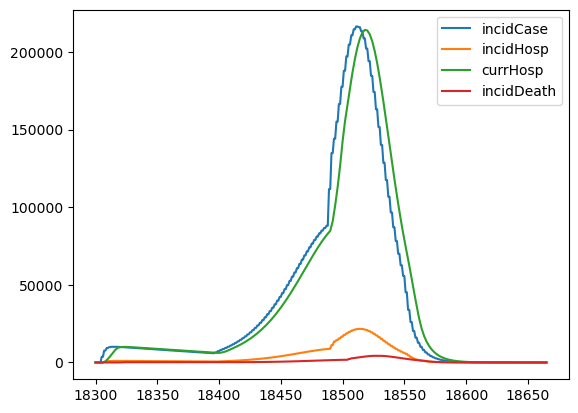

In [2]:
if False:
    p_gt = gempyor_inference.inferpar.draw_initial(n_draw=1)[0]
    np.save("parameter_ground_truth.npy", p_gt)
    # run with the gt
    snpi_df_mod, hnpi_df_mod = gempyor_inference.inferpar.inject_proposal(proposal=p_gt, 
                                                                          snpi_df=gempyor_inference.static_sim_arguments["snpi_df_ref"], 
                                                                          hnpi_df = gempyor_inference.static_sim_arguments["hnpi_df_ref"])
        
    ss = copy.deepcopy(gempyor_inference.static_sim_arguments)
    ss["snpi_df_in"] = snpi_df_mod
    ss["hnpi_df_in"] = hnpi_df_mod
    del ss["snpi_df_ref"]
    del ss["hnpi_df_ref"]

        
    gt_df = gempyor.inference.simulation_atomic(**ss, modinf=gempyor_inference.modinf, save=False)
    gempyor.write_df(fname = "model_input/data/generated_gt_data.csv", df=gt_df.reset_index())

gt_df = gempyor.read_df(fname = "model_input/data/generated_gt_data.csv")
gt_df[gt_df["subpop"]=="06000"].plot()

## Run EMCEE

In [ ]:
if True:
    filename = f"{run_id}_backend.h5"

    
    backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, gempyor_inference.inferpar.get_dim())
    # p0 = gempyor_inference.inferpar.draw_initial(n_draw=nwalkers)
    # for i in range(nwalkers):
    #     assert gempyor_inference.inferpar.check_in_bound(
    #         proposal=p0[i]
    #     ), "The initial parameter draw is not within the bounds, check the perturbation distributions"
    p0=None
    moves = [(emcee.moves.StretchMove(live_dangerously=True), 1)]
    #moves = [(DIMEMove(),1)]
    gempyor_inference.set_silent(True)
    with multiprocessing.Pool(ncpu) as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            gempyor_inference.inferpar.get_dim(),
            gempyor_inference.get_logloss_as_single_number,
            pool=pool,
            backend=backend,
            moves=moves,
        )
        state = sampler.run_mcmc(p0, niter, progress=True, skip_initial_state_check=True)

    print(f"Done, mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

In [12]:
if True:
    filename = f"{run_id}_backend.h5"

    
    backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, gempyor_inference.inferpar.get_dim())
    # p0 = gempyor_inference.inferpar.draw_initial(n_draw=nwalkers)
    # for i in range(nwalkers):
    #     assert gempyor_inference.inferpar.check_in_bound(
    #         proposal=p0[i]
    #     ), "The initial parameter draw is not within the bounds, check the perturbation distributions"
    p0=None
    moves = [(emcee.moves.StretchMove(live_dangerously=True), 1)]
    #moves = [(DIMEMove(),1)]
    gempyor_inference.set_silent(True)
    from mpi4py.futures import MPIPoolExecutor
    with MPIPoolExecutor(4) as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            gempyor_inference.inferpar.get_dim(),
            gempyor_inference.get_logloss_as_single_number,
            pool=pool,
            backend=backend,
            moves=moves,
        )
        state = sampler.run_mcmc(p0, niter, progress=True, skip_initial_state_check=True)

    print(f"Done, mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

# Analysis

In [9]:
filename = f"{run_id}_backend.h5"
sampler = emcee.backends.HDFBackend(filename, read_only=True)
param_gt=np.load("parameter_ground_truth.npy")
llik_gt = gempyor_inference.get_logloss_as_single_number(param_gt)
gempyor.postprocess_inference.plot_chains(
        inferpar=gempyor_inference.inferpar, chains=sampler.get_chain(), 
        llik=sampler.get_log_prob(), 
        sampled_slots=None, save_to=f"{run_id}_chains.pdf",
        param_gt=param_gt, 
        llik_gt=llik_gt
    )

generating chain plot


100%|██████████| 51/51 [00:14<00:00,  3.61it/s]


In [10]:
shutil.rmtree("model_output/", ignore_errors=True)
shutil.rmtree(project_path + "model_output/", ignore_errors=True)
max_indices = np.argsort(sampler.get_log_prob()[-1, :])[-int(nsamples):]
samples = sampler.get_chain()[-1, max_indices, :]  # the last iteration, for selected slots
gempyor_inference.set_save(True)
with multiprocessing.Pool(ncpu) as pool:
    results = pool.starmap(
        gempyor_inference.get_logloss_as_single_number, [(samples[i, :],) for i in range(len(max_indices))]
    )
results = []
for fn in gempyor.utils.list_filenames(folder=project_path+"model_output/", filters=[run_id, "hosp.parquet"]):
    df = gempyor.read_df(fn)
    df = df.set_index("date")
    results.append(df)

In [11]:
def plot_fit(modinf, inferpar, loss, list_of_df, save_to):
    with PdfPages(f"{save_to}") as pdf:
            d = pdf.infodict()
            d["Title"] = "FlepiMoP Inference Fit"
            d["Author"] = "FlepiMoP Inference"
            

            for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
                fig, axes = plt.subplots(1, len(loss.statistics), figsize=(3 * len(loss.statistics), 4), sharex=True)
                
                gt_s = loss.gt[loss.gt["subpop"] == subpop].sort_index()
                first_date = max(gt_s.index.min(), list_of_df[0].index.min())
                last_date = min(gt_s.index.max(), list_of_df[0].index.max())
                gt_s = gt_s.loc[first_date:last_date].drop(["subpop"], axis=1).resample("W-SAT").sum()

                for i, (stat_name, stat) in enumerate(loss.statistics.items()):
                    ax = axes[i]
                    ax.plot(gt_s[stat.data_var], color="k", marker=".", lw=1)
                    for model_df in list_of_df:
                        model_df_s = (
                            model_df[model_df["subpop"] == subpop]
                            .drop(["subpop"], axis=1)
                            .loc[first_date:last_date]
                            .resample("W-SAT")
                            .sum()
                        )  # todo sub subpop here
                        ax.plot(model_df_s[stat.sim_var], lw=0.9, alpha=0.5)
                    # if True:
                    #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                    ax.set_title(f"{stat_name}, {subpop}")
                fig.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)
plot_fit(modinf=gempyor_inference.modinf, inferpar=gempyor_inference.inferpar, loss=gempyor_inference.logloss, list_of_df=results, save_to=f"{run_id}_fit.pdf")